# Assignment 7 - Neural Network
Using PyTorch

In [16]:
# import pytorch libraries
import torch
import torch.nn as nn

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import os

# you need to clone the fashion-mnist repository into the current directory
import sys
sys.path.append('fashion-mnist/utils')
import mnist_reader

In [18]:
X_train, y_train = mnist_reader.load_mnist('fashion-mnist/data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('fashion-mnist/data/fashion', kind='t10k')

In [19]:
np.info(X_train)
y_train[:10]

class:  ndarray
shape:  (60000, 784)
strides:  (784, 1)
itemsize:  1
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x19182cb0070
byteorder:  little
byteswap:  False
type: uint8


array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5], dtype=uint8)

In [20]:
# scale data between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
np.max(X_test), np.min(X_test)

(1.8319327731092436, 0.0)

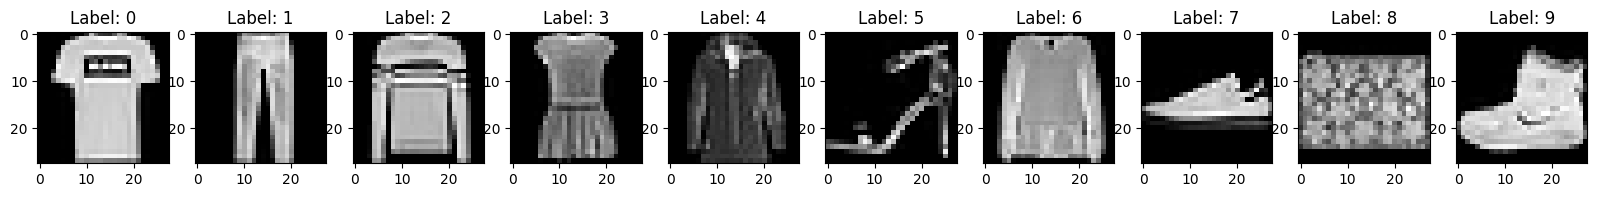

In [22]:
# visualize one image from each of the 10 classes
fig, ax = plt.subplots(1, 10, figsize=(20, 5))

for i in range(10):
    # find the first image with label i
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(f'Label: {i}')


In [23]:
# import train test split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [24]:
# using torch convert sample data in both subsets to a tensor [1, 28, 28]
X_train = torch.tensor(X_train, dtype=torch.float32).view(-1, 1, 28, 28)
X_val = torch.tensor(X_val, dtype=torch.float32).view(-1, 1, 28, 28)

In [25]:
X_train.size(), X_val.size()

(torch.Size([48000, 1, 28, 28]), torch.Size([12000, 1, 28, 28]))

In [26]:
# convert labels to tensor (one hot encoding)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)

# one hot encoding
y_train = torch.nn.functional.one_hot(y_train)
y_val = torch.nn.functional.one_hot(y_val)


## Class `Dataset()`

In [27]:
class Dataset():
    def __init__(self, samples, labels, batch_size):
        self.samples = samples
        self.labels = labels
        self.batch_size = batch_size
    
    def __getitem__(self, index):
        N = self.samples.size(0)
        start = index * self.batch_size
        end = min(N, start + self.batch_size)
        if start >= N:
            raise IndexError('Index out of bounds')
        return self.samples[start:end], self.labels[start:end]

    def __len__(self):
        return (self.samples.size(0) + self.batch_size - 1) // self.batch_size

    def shuffle(self):
        perm = torch.randperm(self.samples.size(0))
        self.samples = self.samples[perm]
        self.labels = self.labels[perm]
    

## Classes `Conv2D`, `MaxPool2d` and `ReLU`

In [42]:
class MaxPool2d(torch.nn.Module):
    def __init__(self, kernel_size, stride):
        super().__init__()
        self.kernel_size = kernel_size
        self.kH = kernel_size[0]
        self.kW = kernel_size[1]
        self.stride = stride
    
    def forward(self, x):
        
        N, C, H, W = x.size()
        
        H_out = (H - self.kH) // self.stride + 1
        W_out = (W - self.kW) // self.stride + 1

        # I did it this way because I didn't really understand the unfold function, especially the stride.
        # return x.unfold(2, self.kH, self.kW).unfold(3, self.kH, self.kW).reshape(N, C, -1, self.kH * self.kW).max(axis=3)[0].view(N, C, H_out, W_out)
        unfold = torch.nn.Unfold(kernel_size=self.kernel_size, stride=(self.stride, self.stride))
        x_unfold = unfold(x)
        x_unfold = x_unfold.view(N, C, self.kH * self.kW, H_out * W_out)
        x_max, _ = x_unfold.max(dim=2)
        x_max = x_max.view(N, C, H_out, W_out)
        return x_max

class ReLU(torch.nn.Module):
    def __init__(self):
        super().__init__()
        pass
    
    def forward(self, x):
        return torch.max(x, torch.zeros_like(x))

In [39]:
class Conv2d(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super().__init__()
        self.in_channels = in_channels # (int)
        self.out_channels = out_channels # (int)
        self.kernel_size = kernel_size # (int, int)
        self.stride = stride # int
        self.groups = 1 # (int) number of blocked connections from input channels to output channels

        # KERNEL INITIALIZATION
        # initialize weights and bias
        k = self.groups / (self.in_channels * self.kernel_size[0] * self.kernel_size[1]) # normalization factor

        self.weight = torch.nn.Parameter(
            torch.Tensor(self.out_channels, self.in_channels//self.groups, self.kernel_size[0], self.kernel_size[1]).uniform_(-np.sqrt(k), np.sqrt(k))
        ) # usage of torch.nn.Parameter to include the tensor in the list of parameters that are returned by the parameters() method
        

        self.bias = torch.nn.Parameter(
            torch.Tensor(self.out_channels).uniform_(-np.sqrt(k), np.sqrt(k))
            ) # initialize bias        
    
    def forward(self, x):
        """
        x : torch.Tensor(N, C, H, W)
        ---
        - Each kernel has its own set of weights and bias. If out_channels = 3, then there are 3 kernels, each with its own set of weights and bias.
        - The forward pass is computed by applying each kernel to the input tensor and summing the results (dot product).
        - The output tensor has shape (N, out_channels, H', W') where H' and W' are the height and width of the output tensor.
        - We use the Unfold operation to extract the patches from the input tensor and apply the kernel to each patch.
        """
        N, C, H, W = x.size()
        # 1. Unfold the input tensor
        unfold = torch.nn.Unfold(kernel_size=self.kernel_size, stride=(self.stride, self.stride))
        x_unfold = unfold(x) # shape (N , C * kernel_size[0] * kernel_size[1], H_out * W_out)

        # 2. reshape the kernel to (out_channels, C * kernel_size[0] * kernel_size[1])
        weight_flat = self.weight.view(self.out_channels, -1)

        # 3. perform matmul
        out = torch.matmul(weight_flat,x_unfold) + self.bias.view(-1, 1)
        
        # 3. Reshape the output tensor
        H_out = (x.size(2) - self.kernel_size[0]) // self.stride + 1
        W_out = (x.size(3) - self.kernel_size[1]) // self.stride + 1

        return out.view(N, self.out_channels, H_out, W_out)

### Testing functions

In [31]:
input_tensor = torch.tensor([[1, 2, 3, 4],
                              [5, 6, 7, 8],
                              [9, 10, 11, 12],
                              [13, 14, 15, 16]]).float().unsqueeze(0).unsqueeze(0)

# Unfold with a 2x2 kernel, stride=1, no padding
unfolded = torch.nn.functional.unfold(input_tensor, kernel_size=(3, 3), stride=(1,1), padding=0)

print("Unfolded tensor shape:", unfolded.shape)  # (1, 4, 9) -> (batch, kernel size, patches)
print("Unfolded tensor:\n", unfolded)


Unfolded tensor shape: torch.Size([1, 9, 4])
Unfolded tensor:
 tensor([[[ 1.,  2.,  5.,  6.],
         [ 2.,  3.,  6.,  7.],
         [ 3.,  4.,  7.,  8.],
         [ 5.,  6.,  9., 10.],
         [ 6.,  7., 10., 11.],
         [ 7.,  8., 11., 12.],
         [ 9., 10., 13., 14.],
         [10., 11., 14., 15.],
         [11., 12., 15., 16.]]])


In [40]:
# Initialize custom Conv2d and PyTorch Conv2d
in_channels, out_channels, kernel_size, stride = 4, 2, (3, 3), 2
custom_conv = Conv2d(in_channels, out_channels, kernel_size, stride)
torch_conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

# Synchronize weights and biases
torch_conv.weight.data = custom_conv.weight.data.clone()
torch_conv.bias.data = custom_conv.bias.data.clone()

# Test with the same input tensor
x = torch.randn(10, in_channels, 5, 5)  # Input tensor
# print(x)
torch_output = torch_conv(x)
# print("\nPyTorch Conv2d Output:")
# print(torch_output)

custom_output = custom_conv(x)


# Compare outputs
# print("Custom Conv2d Output:")
# print(custom_output)


# Verify outputs are identical
difference = torch.abs(custom_output - torch_output).max()
print(f"\nMaximum Difference: {difference.item()}")

# Check if the outputs are the same
assert torch.allclose(custom_output, torch_output, rtol=1e-5, atol=1e-5), "Outputs are not the same!"
print('Custom Conv2d forward pass test passed!')


Maximum Difference: 2.384185791015625e-07
Custom Conv2d forward pass test passed!


In [44]:
# compare with torch.nn.MaxPool2d
x = torch.randn(10, 3, 5, 5)  # input tensor with shape (N, C, H, W)
max_pool = MaxPool2d(kernel_size=(2, 2), stride=4)
output = max_pool.forward(x)
torch_max_pool = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=4)
output_torch = torch_max_pool(x)

# print(output)
# print(output_torch)

assert torch.allclose(output, output_torch)
print('Custom MaxPool2d forward pass test passed!')

Custom MaxPool2d forward pass test passed!


In [256]:
# test relu forward pass
x = torch.randn(10, 3, 5, 5)  # input tensor with shape (N, C, H, W)
relu = ReLU()
output = relu.forward(x)
# output

In [257]:
# compare with torch.nn.functional.relu
assert torch.all(output == torch.nn.functional.relu(x))
print('Custom ReLU forward pass test passed!')

Custom ReLU forward pass test passed!


## Exercice: tensor transformations
Create a PyTorch tensor with random elements in the range [−1, 1]of
dimensions [1, 100, 100]. Pass the tensor through two different transformations indi-
vidually:

In [63]:
# random tensor with values between -1 and 1
random_tensor = torch.rand(1,100,100)*2 - 1 

controlled_tensor = torch.tensor([
    [[-0.5, -0.2, -0.8,  0.9, -0.1],
     [-0.3, -0.6,  -0.7, -0.4,  0.2],
     [-0.9,  -0.1, -0.5, -0.3, -0.7],
     [ 0.8, -0.7,  0.6, -0.2, -0.4],
     [-0.1, -0.9, -0.3,  0.5, -0.6]]
], dtype=torch.float32).unsqueeze(0)  # Add batch dimension

### Function one: `MaxPool2d(kernel_size=3, stride=2)` followed by a `ReLU`

In [57]:
max_pool = MaxPool2d(kernel_size=(3, 3), stride=2)
relu = ReLU()
output1 = relu(max_pool.forward(random_tensor.unsqueeze(0)))

### Function two: `ReLU` followed by a `MaxPool2d(kernel_size=3, stride=2)`

In [58]:
output2 = max_pool.forward(relu(random_tensor.unsqueeze(0)))

In [59]:
# Compare outputs
assert torch.allclose(output1, output2)

In [60]:
difference = output1 - output2
print(difference)
print(torch.sum(difference))  # Total difference
print(torch.mean(difference)) # Average difference
print(torch.max(difference))  # Maximum difference

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])
tensor(0.)
tensor(0.)
tensor(0.)


In [64]:
# Function 1: MaxPool -> ReLU
output1 = relu(max_pool.forward(controlled_tensor))

# Function 2: ReLU -> MaxPool
output2 = max_pool.forward(relu(controlled_tensor))


print("Output 1 (MaxPool -> ReLU):\n", output1)
print("Output 2 (ReLU -> MaxPool):\n", output2)

difference = output1 - output2
print("Difference:\n", difference)
print("Are the tensors close?", torch.allclose(output1, output2, rtol=1e-07, atol=1e-09))

Output 1 (MaxPool -> ReLU):
 tensor([[[[0.0000, 0.9000],
          [0.8000, 0.6000]]]])
Output 2 (ReLU -> MaxPool):
 tensor([[[[0.0000, 0.9000],
          [0.8000, 0.6000]]]])
Difference:
 tensor([[[[0., 0.],
          [0., 0.]]]])
Are the tensors close? True


### Results
We observe that both outputs are equals. Why is that?
- In the first function, we extract the maximum values from the local patches of `random_tensor` of size $3 \times 3$. This gives us a $2 \times 2$ matrix (1,1,2,2 tensor) that is then passed through a the `ReLU` function. So:
    - if there are local patches full of negative values, the maxpooling will result into a negative maximum, that will be set to zero by the ReLU.
    - If there are local patches with at least one positive value, the maxpooling -> ReLU will result into the maximum positive value.
- In the second function, we first pass the `random_tensor` into the `ReLU` function. This gives us a tensor with values between $[0,1]$ by setting all negative values to $0$. Then the `MaxPool2d` selects the maximum value into the local patches extracted form this tensor.

So mathematically, we have :
- `MaxPool2d` $\rightarrow$ `ReLU` is $\max( \max(\{\text{patch of } x \}) , 0) = \max ( \{\text{patch of } x \})_+$,
- `ReLU` $\rightarrow$ `MaxPool2d` is $\max( \{\text{patch of } \max(x , 0) \}) = \max ( \{\text{patch of } x_+ \})$.

So basically, since each local patch can be represented as a vector (flattenning the kernel), we can then try to prove $\forall x \in \mathbb R^n, n \in \mathbb N$:
$$\max(x)_+ = \max(x_+)$$

#### Proof
Let $x = (x_1, x_2, \dots, x_n)$ be a vector in $\mathbb R^n$. We have:
- $\max(x) = \max\{x_1,x_2,\dots,x_n\} \in \mathbb R$
- $\max(x)_+ = \max(\max(x),0) \in \mathbb R$
- $x_+ = (\max(x_1,0), \max(x_2,0), \dots, \max(x_n,0)) \in \mathbb R^n$

Let $m = \max(x) = \max\{x_1,x_2,\dots,x_n\}$. 

1. Consider $\max(x)_+ = \max(m,0)$.
    - If $m \ge 0$, then $\max(m,0) = m$
    - If $m < 0$, then $\max(m,0) = 0$

2. Moreover, consider $x_+ = (\max(x_1,0), \max(x_2,0), \dots, \max(x_n,0))$.
    - If $m \ge 0$, then $\exists k \in \{1,\dots,n\}$ such that $x_k = m \ge 0$. So the $k$-th component of $x_+$ is $\max(m, 0) = m.$ So $\max(x_+) \ge m$.
    - Also, for any $i \in \{1,\dots,n\}, x_{i+} = \max(x_i,0) \le \max(m, 0)$. Thus $\max(x_+) \le m$.
    - Combining both results in $\max(x_+) = m$.

    Futhermore, if $m < 0$, then $\forall i, x_i < 0 \implies \forall i, \max(x_i,0) = 0$. Thus $\max(x_+) = 0$.

**Putting all together**
- If $m \ge 0$, then $\max(x)_+ = \max(m, 0) = m$ and $\max(x_+) = m$
- If $m < 0$, then $\max(x)_+ = \max(m, 0) = 0$ and $\max(x_+) = 0$

Hence, in either case,
$$
\max(x)_+ = \max(x_+)
$$
for all $x \in \mathbb R^n$.


## Exercice: defining the Neural Network
After the second block, we need a tensor of size [B, 64, 4, 4].
Since we have a Dataset of size [N, 1, 28, 28], each image is size $28 \times 28$.
My NN will be:
- `Conv2D` with `kernel_size=(3,3), stride=1` so the feature maps stays $28 \times 28$,
- `MaxPool2d` with `kernel_size=(7,7), stride=7` so $28 \rightarrow 4$ (since $\lfloor{\frac{28-(6-1)}{6}}\rfloor + 1 = 4$),
- ReLU,
- `Conv2D` with `kernel_size=(4,4), stride=1` to get a final tensor of size [B, 10, 1, 1],
- `Flatten` to get a final output of size [B, 10].

In [71]:
kernel_size = (3, 3)
out_channels = 64
in_channels = 1

custom_model = torch.nn.Sequential(
    Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1),
    # output (B, 64, 28, 28)

    MaxPool2d(kernel_size=(6, 6), stride=6),
    # output(B, 64, 4, 4)

    ReLU(),
    # output(B, 64, 4, 4)

    Conv2d(in_channels=64, out_channels=10, kernel_size=(4, 4), stride=1),
    # output(B, 10, 1, 1)

    torch.nn.Flatten()
    # output(B, 10)
)

torch_model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=1),
    torch.nn.MaxPool2d(kernel_size=(6, 6), stride=6),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(4, 4), stride=1),
    torch.nn.Flatten()
)

# quick test
x = torch.randn(20, 1, 28, 28)
output_custom = custom_model(x)
print(output_custom.size())

output_torch = torch_model(x)
print(output_torch.size())


torch.Size([20, 10])
torch.Size([20, 10])


In [81]:
def fit(
        model,
        train_dataset,          # training Dataset object
        val_dataset,            # validation Dataset object
        criterion = torch.nn.CrossEntropyLoss(),
        lr=0.001,               # learning rate
        number_of_epochs=10,          # number of epochs
        device='cpu',           # device
):
        """
        model: torch.nn.Module
                Model to train (custom_model or torch_model).
        train_dataset: Dataset
                An instance of the custom Dataset class for training.
        val_dataset: Dataset
                An instance of the custom Dataset class for validation.
        criterion: torch.nn.Module
                Loss function (default CrossEntropy).
        lr: float
                Learning rate for optimizer.
        num_epochs: int
                Number of epochs to train.
        device: str
                'cpu' or 'cuda' device to run training/validation on.

        Returns
        -------
        best_model: nn.Module
                Model weights corresponding to the best validation loss.
        training_losses: list
                List of average training losses for each epoch.
        validation_losses: list
                List of average validation losses for each epoch.
        """

        # move model to device
        model = model.to(device)

        # initialize optimizer
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)

        # initialize lists to store loss values
        training_losses = []
        validation_losses = []

        # initialize best model and best validation loss
        best_model = None
        best_val_loss = float('inf')

        # loop over the number of epochs
        for epoch in range(number_of_epochs):
                # ------------------- TRAINING ------------------------------
                model.train() # set model to training mode

                train_dataset.shuffle() # shuffle training data

                running_loss = 0.0 

                # loop over the mini-batches in the training dataset
                for inputs, labels in train_dataset:
                        # move data to device
                        inputs, labels = inputs.to(device), labels.to(device)

                        # initialize gradients to zero from the previous iteration
                        optimizer.zero_grad()

                        # forward pass
                        outputs = model(inputs)

                        # calculate loss
                        loss = criterion(outputs, torch.argmax(labels, dim=1))

                        # backward pass
                        loss.backward()

                        # optimize
                        optimizer.step()

                        # update running loss
                        running_loss += loss.item()

                # calculate average training loss
                training_loss = running_loss / len(train_dataset)
                training_losses.append(training_loss)

                # ------------------- VALIDATION ------------------------------
                model.eval() # set model to evaluation mode
                
                running_loss = 0.0

                # loop over the mini-batches in the validation dataset
                for inputs, labels in val_dataset:
                        # move data to device
                        inputs, labels = inputs.to(device), labels.to(device)

                        # forward pass
                        outputs = model(inputs)

                        # calculate loss
                        loss = criterion(outputs, torch.argmax(labels, dim=1))

                        # update running loss
                        running_loss += loss.item()
                
                # calculate average validation loss
                validation_loss = running_loss / len(val_dataset)
                validation_losses.append(validation_loss)

                # check if validation loss is the best so far
                if validation_loss < best_val_loss:
                        best_val_loss = validation_loss
                        best_model_state = model.state_dict()
                
                # print progress
                print(f'Epoch {epoch+1}/{number_of_epochs}, Training Loss: {training_loss:.4f}, Validation Loss: {validation_loss:.4f}')

        # Create a new instance of the same model class and load best weights
        best_model = model
        best_model.load_state_dict(best_model_state)
        best_model.to(device)
        
        return best_model, training_losses, validation_losses

In [89]:
# Check if cuda is available (PyTorch documentation)
if torch.cuda.is_available():
    print("CUDA is available! PyTorch can use GPUs!")
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")

    # Get the name of each GPU
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

    # Get the index of the current device
    current_device_index = torch.cuda.current_device()
    print(f"Current device index: {current_device_index}")
    print(f"Current device name: {torch.cuda.get_device_name(current_device_index)}")
else:
    print("CUDA is not available. PyTorch will use CPU.")

CUDA is available! PyTorch can use GPUs!
Number of GPUs available: 1
GPU 0: NVIDIA GeForce GTX 1650
Current device index: 0
Current device name: NVIDIA GeForce GTX 1650


In [82]:
train_dataset = Dataset(X_train, y_train, batch_size=64)
val_dataset = Dataset(X_val, y_val, batch_size=64)

input, labels = train_dataset[0]
print(input.size(), labels.size())

torch.Size([64, 1, 28, 28]) torch.Size([64, 10])


In [85]:
best_custom_model, custom_train_losses, custom_val_losses = fit(
    model=custom_model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    device='cuda'
)

Epoch 1/10, Training Loss: 2.0503, Validation Loss: 1.8037
Epoch 2/10, Training Loss: 1.6164, Validation Loss: 1.4482
Epoch 3/10, Training Loss: 1.3323, Validation Loss: 1.2298
Epoch 4/10, Training Loss: 1.1605, Validation Loss: 1.0985
Epoch 5/10, Training Loss: 1.0542, Validation Loss: 1.0148
Epoch 6/10, Training Loss: 0.9835, Validation Loss: 0.9557
Epoch 7/10, Training Loss: 0.9328, Validation Loss: 0.9129
Epoch 8/10, Training Loss: 0.8945, Validation Loss: 0.8790
Epoch 9/10, Training Loss: 0.8638, Validation Loss: 0.8522
Epoch 10/10, Training Loss: 0.8388, Validation Loss: 0.8297


In [ ]:
best_torch_model, torch_train_losses, torch_val_losses = fit(
    model=torch_model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    device='cuda'
)

Epoch 1/10, Training Loss: 2.0422, Validation Loss: 1.8085
Epoch 2/10, Training Loss: 1.6240, Validation Loss: 1.4568
Epoch 3/10, Training Loss: 1.3387, Validation Loss: 1.2341
Epoch 4/10, Training Loss: 1.1626, Validation Loss: 1.0988
Epoch 5/10, Training Loss: 1.0532, Validation Loss: 1.0122
Epoch 6/10, Training Loss: 0.9804, Validation Loss: 0.9523
Epoch 7/10, Training Loss: 0.9286, Validation Loss: 0.9082
Epoch 8/10, Training Loss: 0.8891, Validation Loss: 0.8734
Epoch 9/10, Training Loss: 0.8576, Validation Loss: 0.8449
Epoch 10/10, Training Loss: 0.8316, Validation Loss: 0.8222


In the end, we have similar results, but the `fit` function using **torch's model** is way more efficient (25.3s compared to 1m40s to our custom model).

True label: Dress
Prediction label: Dress


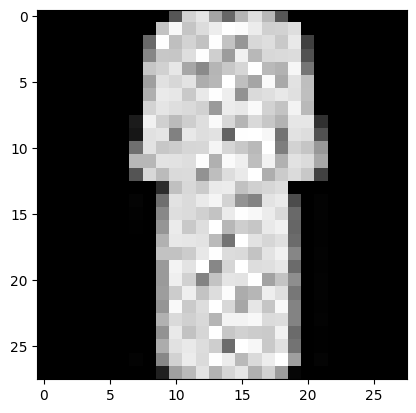

In [193]:
# test example
# draw a random sample from the validation dataset
inputs, labels = val_dataset[0]
inputs, labels = inputs.to('cuda'), labels.to('cuda')

# get the predictions from the best custom model
outputs_custom = best_custom_model(inputs)

# get the predictions from the best torch model
outputs_torch = best_torch_model(inputs)

i = np.random.randint(0, 64)

# plot the img
plt.imshow(inputs[i].cpu().squeeze(), cmap='gray')

# print the true label
labels_desc = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print("True label: " + labels_desc[torch.argmax(labels, axis=1)[i]])

# print the custom model prediction
print("Prediction label: " + labels_desc[torch.argmax(outputs_custom, axis=1)[i]])